### Importing necessary libraries

In [1]:
import json
import os
import time
import warnings

from dotenv import load_dotenv
from functools import partial
from pathlib import Path

import html2text
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import openai
import requests
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearnrag.config import WORK_DIR
from pinecone import Pinecone, ServerlessSpec
from tqdm import tqdm

from sklearnrag.parser import extract_sections

warnings.filterwarnings("ignore")
load_dotenv()

True

### Loading the docs

In [2]:
DOCS_DIR = Path(WORK_DIR, "scikit-learn.org/stable/")
html_files = [path for path in DOCS_DIR.rglob("*html") if not path.is_dir() and "lite" not in path.parts]

print(f"{len(html_files)} documents")

1002 documents


### Extracting all sections from each page

In [3]:
all_sections = list()

for file in tqdm(html_files):
    for section in extract_sections({'path': str(file)}):
        all_sections.append(section)
        
sections_count = len(all_sections)

print(f"Total sections :{sections_count}")

100%|███████████████████████████████████████| 1002/1002 [00:55<00:00, 18.12it/s]

Total sections :3396


In [4]:
sample_html_fp = Path(WORK_DIR, "scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html")
sample_page = extract_sections({"path": sample_html_fp})


print(f"Source : {sample_page[0]['source']}")
print("--"*100)
print(f"Text : \n {sample_page[0]['text'][:200]}")

Source : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Text : 
 #  [ ` sklearn.model_selection  ` ](../classes.html#module-
sklearn.model_selection "sklearn.model_selection") .train_test_split [ ¶
](sklearn.model_selection.train_test_split.html#sklearn-model-selec


### Distribution of different section lengths

In [5]:
sections_df = pd.DataFrame(all_sections)

In [6]:
sections_df.head()

,source,text
0,https://scikit-learn.org/stable/related_projec...,# Related Projects [ ¶ ](related_projects.htm...
1,https://scikit-learn.org/stable/related_projec...,## Interoperability and framework enhancement...
2,https://scikit-learn.org/stable/related_projec...,## Other estimators and tasks [ ¶ ](related_p...
3,https://scikit-learn.org/stable/related_projec...,## Statistical learning with Python [ ¶ ](rel...
4,https://scikit-learn.org/stable/related_projec...,### Recommendation Engine packages [ ¶\n](rel...


In [7]:
sections_df['length'] = sections_df['text'].apply(len)

In [8]:
sections_df.shape

(3396, 3)

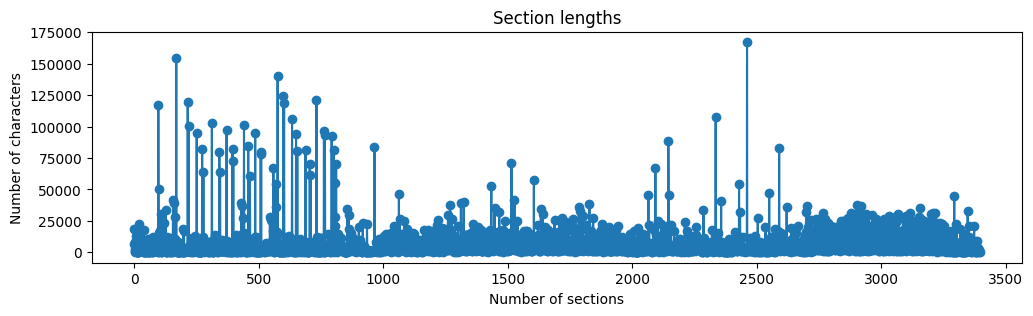

In [9]:
# Plot
plt.figure(figsize=(12, 3))
plt.plot(sections_df['length'], marker='o')
plt.title("Section lengths")
plt.xlabel("Number of sections")
plt.ylabel("Number of characters")
plt.show()

### Chunking 

In [10]:
from sklearnrag.chunk import chunk_sections

In [11]:
chunks = chunk_sections(all_sections,chunk_size=1000, chunk_overlap=100)

In [12]:
len(chunks)

30849

In [13]:
# Sample chunk
chunks[0]

{'text': '#  Related Projects [ ¶ ](related_projects.html#related-projects "Link to this\nheading")\n\nProjects implementing the scikit-learn estimator API are encouraged to use the\n[ scikit-learn-contrib template ](https://github.com/scikit-learn-\ncontrib/project-template) which facilitates best practices for testing and\ndocumenting estimators. The [ scikit-learn-contrib GitHub organization\n](https://github.com/scikit-learn-contrib/scikit-learn-contrib) also accepts\nhigh-quality contributions of repositories conforming to this template.\n\nBelow is a list of sister-projects, extensions and domain specific packages.\n\n##  Interoperability and framework enhancements [ ¶\n](related_projects.html#interoperability-and-framework-enhancements "Link to\nthis heading")\n\nThese tools adapt scikit-learn for use with other technologies or otherwise\nenhance the functionality of scikit-learn’s estimators.\n\n**Data formats**',
 'source': 'https://scikit-learn.org/stable/related_projects.htm

### Embedding the data

In [14]:
from sklearnrag.embedding import EmbedChunks

EMBEDDING_MODELS = {}

#### 1. thenlper/gte-base

In [15]:
def load_or_create_embeddings(model_name, chunks, chunk_size = 1000):
    embeddings_file_name = f"{model_name.split('/')[-1]}-{chunk_size}.json"
    embeddings_file_path = Path(WORK_DIR, "saved_embeddings", embeddings_file_name)
    
    # Check if embeddings file exists
    if embeddings_file_path.exists():
        with open(embeddings_file_path, 'r') as file:
            embeddings = json.load(file)
    else:
        # Initialize the embedding model
        embedder = EmbedChunks(model_name=model_name)
        embeddings = embedder.process_chunks(chunks)
        
        # Save the embeddings to a file
        with open(embeddings_file_path, 'w') as file:
            json.dump(embeddings, file, indent=4)
    
    return embeddings

In [16]:
model_name = "thenlper/gte-base"
chunk_size = 1000

# Load or create embeddings
embeddings = load_or_create_embeddings(model_name, chunks, chunk_size)
EMBEDDING_MODELS[model_name] = embeddings

In [17]:
EMBEDDING_MODELS.keys()

dict_keys(['thenlper/gte-base'])

#### 2. thenlper/gte-large

In [18]:
model_name = "thenlper/gte-large"
chunk_size = 1000

# Load or create embeddings
embeddings = load_or_create_embeddings(model_name, chunks, chunk_size)
EMBEDDING_MODELS[model_name] = embeddings

In [19]:
EMBEDDING_MODELS.keys()

dict_keys(['thenlper/gte-base', 'thenlper/gte-large'])

#### 3. text-embedding-3-large	

In [20]:
model_name = "text-embedding-3-large"
chunk_size = 1000

# Load or create embeddings
embeddings = load_or_create_embeddings(model_name, chunks, chunk_size)
EMBEDDING_MODELS[model_name] = embeddings

In [21]:
EMBEDDING_MODELS.keys()

dict_keys(['thenlper/gte-base', 'thenlper/gte-large', 'text-embedding-3-large'])

### Upserting embeddings to Pinecone

In [22]:
from pinecone import Pinecone
from sklearnrag.vectordb import PineconeIndex

In [23]:
PINECONE_INDEXES = {}

In [24]:
def load_or_create_index(index_name):
    pc = PineconeIndex()
    
    existing_indexes = [
        index_info["name"] for index_info in Pinecone().list_indexes()
    ]
    
    if index_name not in existing_indexes:
        index = pc.create_index(index_name, 768)
        index = pc.get_index(index_name)
        pc.upsert_data(index, EMBEDDING_MODELS['thenlper/gte-base'])
    
    PINECONE_INDEXES[index_name] = pc.Index(index_name) 
    
    return PINECONE_INDEXES[index_name]

#### 1. thenlper/gte-base

In [25]:
index_name = "gte-base-1000"
load_or_create_index(index_name)

In [26]:
PINECONE_INDEXES

{'gte-base-1000': <pinecone.data.index.Index at 0x31170ed30>}

#### 2. thenlper/gte-large

In [27]:
index_name = "gte-large-1000"
load_or_create_index(index_name)

In [28]:
PINECONE_INDEXES

{'gte-base-1000': <pinecone.data.index.Index at 0x31170ed30>,
 'gte-large-1000': <pinecone.data.index.Index at 0x163b4bbe0>}

#### 3. text-embedding-3-large	

In [29]:
index_name = "text-embedding-3-large-1000"
load_or_create_index(index_name)

In [30]:
PINECONE_INDEXES

{'gte-base-1000': <pinecone.data.index.Index at 0x31170ed30>,
 'gte-large-1000': <pinecone.data.index.Index at 0x163b4bbe0>,
 'text-embedding-3-large-1000': <pinecone.data.index.Index at 0x46e5c7e50>}

### Retrieval

In [35]:
from sklearnrag.search import semantic_search
from sklearnrag.embedding import get_embedding_model
import torch

In [41]:
query = "How do i divide my dataset into train, test and validation split?"
index = PINECONE_INDEXES["gte-base-1000"]
embedding_model_name = "thenlper/gte-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

embedding_model = get_embedding_model(
            embedding_model_name=embedding_model_name,
            model_kwargs={"device": device},
            encode_kwargs={"device": device, "batch_size": 100},)

semantic_search(query,index,embedding_model,5)

[{'id': '14056',
  'text': '# Split dataset to select feature and evaluate the classifier\n    X_train, X_test, y_train, y_test = [train_test_split](../../modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split "sklearn.model_selection.train_test_split")(X, y, stratify=y, random_state=0)\n    \n[/code]',
  'source': 'https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#generate-sample-data'},
 {'id': '14037',
  'text': '# Split dataset to select feature and evaluate the classifier\n    X_train, X_test, y_train, y_test = [train_test_split](../../modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split "sklearn.model_selection.train_test_split")(X, y, stratify=y, random_state=0)\n    \n[/code]',
  'source': 'https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#univariate-feature-selection'},
 {'id': '12539',
  'text

### Generate response

In [46]:
def response_stream(chat_completion):
    for chunk in chat_completion:
        content = chunk.choices[0].delta.content
        if content is not None:
            yield content

def prepare_response(chat_completion, stream):
    if stream:
        return response_stream(chat_completion)
    else:
        return chat_completion.choices[0].message.content

def get_client(llm):
    if llm.startswith("gpt"):
        base_url = os.environ["OPENAI_API_BASE"]
        api_key = os.environ["OPENAI_API_KEY"]
    else:
        base_url = os.environ["ANYSCALE_API_BASE"]
        api_key = os.environ["ANYSCALE_API_KEY"]
    client = openai.OpenAI(base_url = base_url, api_key=api_key)
    return client

In [47]:
def generate_response(llm, temperature=0.0, stream=True, system_content="",
                      assistant_content="", user_content="", max_retries=1, retry_interval=60):
    """Generate response from an LLM."""
    retry_count = 0
    client = get_client(llm=llm)
    messages = [{"role": role, "content": content} for role, content in [
        ("system", system_content), 
        ("assistant", assistant_content), 
        ("user", user_content)] if content]
    while retry_count <= max_retries:
        try:
            chat_completion = client.chat.completions.create(
                model=llm,
                temperature=temperature,
                stream=stream,
                messages=messages,
            )
            return prepare_response(chat_completion, stream=stream)

        except Exception as e:
            print(f"Exception: {e}")
            time.sleep(retry_interval)  # default is per-minute rate limits
            retry_count += 1
    return ""

In [48]:
query = "What are the required parameters for train_test_split method?"
context_results = semantic_search(query=query, embedding_model=embedding_model, index=index, k=5)
context = [item["text"] for item in context_results]
sources = [item["source"] for item in context_results]

In [49]:
for text, source in zip(context,sources):
    print(source)
    print(text)
    print("--"*50)

https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#effect-of-transforming-the-targets-in-regression-model
X_train, X_test, y_train, y_test = [train_test_split](../../modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split "sklearn.model_selection.train_test_split")(X, y, random_state=0)
    
[/code]
----------------------------------------------------------------------------------------------------
https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#synthetic-example
X_train, X_test, y_train, y_test = [train_test_split](../../modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split "sklearn.model_selection.train_test_split")(X, y, random_state=0)
    
[/code]
----------------------------------------------------------------------------------------------------
https://scikit-learn.org/stable/modules/generated/sklearn.model_selecti

In [50]:
# Generate response
query = "What are the required parameters for train_test_split method?"
response = generate_response(
    llm="mistralai/Mixtral-8x7B-Instruct-v0.1",
    temperature=0.0,
    stream=True,
    system_content="Answer the query purely using the context provided. Do not try to make things up. Be succinct.",
    user_content=f"query: {query}, context: {context}")

# Stream response
for content in response:
    print(content, end='', flush=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 The required parameters for the `train_test_split` method are `arrays`, `test_size`, and optionally `random_state`. Here, `arrays` refers to the data to be split, which can be a single array or a list of arrays, while `test_size` represents the proportion of the data to include in the test split (a value between 0 and 1). The `random_state` parameter is used for initializing the internal random number generator, which will decide the splitting of data into train and test indices.

### Agent

In [52]:
import tiktoken

def get_num_tokens(text):
    enc = tiktoken.get_encoding("cl100k_base")
    return len(enc.encode(text))


def trim(text, max_context_length):
    enc = tiktoken.get_encoding("cl100k_base")
    return enc.decode(enc.encode(text)[:max_context_length])

MAX_CONTEXT_LENGTHS = {'gpt-4': 8192,
 'gpt-3.5-turbo': 4096,
 'gpt-4-turbo-2024-04-09' : 128000,
 'meta-llama/Llama-2-70b-chat-hf': 4096,
 'mistralai/Mistral-7B-Instruct-v0.1': 8192,
 'mistralai/Mixtral-8x7B-Instruct-v0.1': 32768}

In [56]:
class QueryAgent:
    def __init__(self, embedding_model_name="thenlper/gte-base",
                 llm="mistralai/Mixtral-8x7B-Instruct-v0.1", temperature=0.0, 
                 max_context_length=4096, system_content="", assistant_content=""):
        
        # Embedding model
        self.embedding_model = get_embedding_model(
            embedding_model_name=embedding_model_name, 
            model_kwargs={"device": "mps"}, 
            encode_kwargs={"device": "mps", "batch_size": 100})
        
        # Context length (restrict input length to 50% of total context length)
        max_context_length = int(0.5*max_context_length)
        
        # LLM
        self.llm = llm
        self.temperature = temperature
        self.context_length = max_context_length - get_num_tokens(system_content + assistant_content)
        self.system_content = system_content
        self.assistant_content = assistant_content

    def __call__(self, query, num_chunks=5, stream=True):
        # Get sources and context
        context_results = semantic_search(
            query=query, 
            embedding_model=self.embedding_model,
            index=index, 
            k=num_chunks)
            
        # Generate response
        context = [item["text"] for item in context_results]
        sources = [item["source"] for item in context_results]
        user_content = f"query: {query}, context: {context}"
        answer = generate_response(
            llm=self.llm,
            temperature=self.temperature,
            stream=stream,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=trim(user_content, self.context_length))

        # Result
        result = {
            "question": query,
            "sources": sources,
            "answer": answer,
            "llm": self.llm,
        }
        return result

In [59]:
embedding_model_name = "thenlper/gte-base"
llm = "mistralai/Mixtral-8x7B-Instruct-v0.1"

In [60]:
query = "What is the default number of clusters in Kmeans?"

system_content = "Answer the query purely using the context provided. Do not try to make things up. Be succinct."
agent = QueryAgent(
    embedding_model_name=embedding_model_name,
    llm=llm,
    max_context_length=MAX_CONTEXT_LENGTHS[llm],
    system_content=system_content)

result = agent(query=query, stream=False, num_chunks=10)
print(json.dumps(result, indent=2))

{
  "question": "What is the default number of clusters in Kmeans?",
  "sources": [
    "https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#possible-solutions",
    "https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn-cluster-minibatchkmeans",
    "https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#demonstration-of-k-means-assumptions",
    "https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#fit-models-and-plot-results",
    "https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#k-means-clustering-on-text-features",
    "https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#clustering-text-documents-using-k-means",
    "https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#clustering-sparse-data-with-k-means",
    "https://scikit-learn.org/stable/auto_examples/cluster/p

### Evaluation

In [61]:
from bs4 import BeautifulSoup
from IPython.display import JSON, clear_output, display
from tqdm import tqdm
import urllib.parse
import re

In [68]:
def extract_from_response(response):
    # Define regular expressions for extracting values
    answer_pattern = r'"answer"\s*:\s*"([^"]*)"'
    score_pattern = r'"score"\s*:\s*([0-9]+)'
    reasoning_pattern = r'"reasoning"\s*:\s*"([^"]*)"'

    # Extract values using regular expressions
    answer_match = re.search(answer_pattern, response)
    score_match = re.search(score_pattern, response)
    reasoning_match = re.search(reasoning_pattern, response)

    # Convert
    if answer_match and score_match and reasoning_match:
        answer = answer_match.group(1)
        score = float(score_match.group(1))
        reasoning = reasoning_match.group(1)
        return answer, score, reasoning

    return "", "", ""

def fetch_text(uri):
    url, anchor = uri.split("#") if "#" in uri else (uri, None)
    file_path = Path(WORK_DIR, url.split("https://")[-1])
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, "html.parser")
    if anchor:
        target_element = soup.find(id=anchor)
        if target_element:
            text = target_element.get_text()
        else:
            return fetch_text(uri=url)
    else:
        text = soup.get_text()
    return text

In [69]:
with open("evaluation_datasets/eval-data-reduced-gpt-4.json", "r") as f:
    eval_data = json.load(f)

In [70]:
eval_data[30]['source']

'https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn-gaussian-process-kernels-rbf'

In [71]:
eval_data[30]['question']

'Why is the RBF kernel often preferred in Gaussian Process models for complex datasets?'

In [72]:
# Sample
uri = eval_data[30]['source']
print(fetch_text(uri=uri))


sklearn.gaussian_process.kernels.RBF¶


class sklearn.gaussian_process.kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0))[source]¶
Radial basis function kernel (aka squared-exponential kernel).
The RBF kernel is a stationary kernel. It is also known as the
“squared exponential” kernel. It is parameterized by a length scale
parameter \(l>0\), which can either be a scalar (isotropic variant
of the kernel) or a vector with the same number of dimensions as the inputs
X (anisotropic variant of the kernel). The kernel is given by:

\[k(x_i, x_j) = \exp\left(- \frac{d(x_i, x_j)^2}{2l^2} \right)\]
where \(l\) is the length scale of the kernel and
\(d(\cdot,\cdot)\) is the Euclidean distance.
For advice on how to set the length scale parameter, see e.g. [1].
This kernel is infinitely differentiable, which implies that GPs with this
kernel as covariance function have mean square derivatives of all orders,
and are thus very smooth.
See [2], Chapter 4, Section 4.2, for further d

In [73]:
# Content for inference
system_content = """
    Answer the query using the context provided. Be succinct.
    Then, you must {score} your response between 1 and 5.
    You must return your response in a line with only the score.
    Do not add any more details.
    On a separate line provide your {reasoning} for the score as well.
    Return your response following the exact format outlined below.
    Do not add or remove anything.
    And all of this must be in a valid JSON format.
    
    {"answer": answer,
     "score": score,
     "reasoning": reasoning}
    """
assistant_content = ""

In [74]:
class QueryAgentWithContext(QueryAgent):
    def __call__(self, query, context):
        user_content = f"query: {query}, context: {context}"
        response = generate_response(
            llm=self.llm,
            temperature=self.temperature,
            stream=False,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=user_content[: self.context_length])
        return response

In [75]:
def get_references(data, llm, temperature, system_content, assistant_content, num_samples=None):
    # Initialize agent
    agent = QueryAgentWithContext(
        llm=llm, 
        temperature=temperature,
        system_content=system_content,
        assistant_content=assistant_content)
    
    results = []
    for row in tqdm(data[:num_samples]):
        # Generate response
        query = row["question"]
        context = fetch_text(uri=row["source"])
        response = agent(query=query, context=context)

        # Extract from response
        answer, score, reasoning = extract_from_response(response=response)
        result = ({
                "question": query,
                "source": row["source"],
                "answer": answer,
                "score": score,
                "reasoning": reasoning,
            })
        results.append(result)
        clear_output(wait=True)
        display(JSON(json.dumps(result, indent=2)))
    return results

In [79]:
# gpt-4
results = get_references(
    data=eval_data, num_samples=None, llm="gpt-4-turbo-2024-04-09", temperature=0.0, 
    system_content=system_content, assistant_content=assistant_content)

print(np.mean([float(result["score"]) for result in results if result["score"]]))

4.20815


In [78]:
# Save to file
with open('evaluation-gpt-4.json', "w") as fp:
    json.dump(results, fp, indent=4)

### Experiments

In [3]:
import matplotlib.pyplot as plt
from sklearnrag.generate import generate_responses
from sklearnrag.evaluate import evaluate_responses
from sklearnrag.config import EMBEDDING_DIMENSIONS, MAX_CONTEXT_LENGTHS

In [4]:
llm = "mistralai/Mixtral-8x7B-Instruct-v0.1"
embedding_model_name = "thenlper/gte-large"
EVALUATOR = "gpt-4-turbo-2024-04-09"
EXPERIMENTS_DIR = Path(WORK_DIR, "experiments")
NUM_SAMPLES = None

# Refernces
REFERENCES_FILE_PATH = Path(EXPERIMENTS_DIR, "references", "gpt-4-reduced.json")
REFERENCES_FILE_PATH.parent.mkdir(parents=True, exist_ok=True)

In [5]:
def run_experiment(
    experiment_name,
    chunk_size, chunk_overlap, num_chunks,
    embedding_model_name, embedding_dim,
    llm, evaluator,
    docs_dir, experiments_dir, references_fp,
    system_content="Answer the query using the context provided. Be succinct.",
    num_samples=None):
    """Generate responses and evaluate them."""
    
    # Generate responses
    generate_responses(
        experiment_name=experiment_name, 
        chunk_size=chunk_size, 
        chunk_overlap=chunk_overlap, 
        num_chunks=num_chunks,
        embedding_model_name=embedding_model_name,
        embedding_dim=embedding_dim,
        llm=llm, 
        temperature=0.0, 
        max_context_length=MAX_CONTEXT_LENGTHS[llm], 
        system_content=system_content,
        assistant_content="",
        docs_dir=docs_dir,
        experiments_dir=experiments_dir,
        references_fp=references_fp,
        num_samples = num_samples)

    # Evaluate responses
    evaluation_system_content = """
        Your job is to rate the quality of our generated answer {generated_answer}
        given a query {query} and a reference answer {reference_answer}.
        Your score has to be between 1 and 5.
        You must return your response in a line with only the score.
        Do not return answers in any other format.
        On a separate line provide your reasoning for the score as well.
        """
    evaluate_responses(
        experiment_name=experiment_name,
        evaluator=evaluator, 
        temperature=0.0, 
        max_context_length=MAX_CONTEXT_LENGTHS[evaluator],
        system_content=evaluation_system_content,
        assistant_content="",
        experiments_dir=experiments_dir,
        references_fp=references_fp,
        responses_fp=str(Path(experiments_dir, "responses", f"{experiment_name}.json")),
        num_samples = num_samples)

In [6]:
def print_experiment(experiment_name, experiments_dir, evaluator=EVALUATOR, verbose=True):
    eval_fp = Path(experiments_dir, "evaluations", f"{experiment_name}_{evaluator}.json")
    with open(eval_fp, "r") as fp:
        d = json.load(fp)
    retrieval_score = d["retrieval_score"]
    quality_score = d["quality_score"]
    if verbose:
        print (experiment_name)
        print ("  retrieval score:", retrieval_score)
        print ("  quality score:", quality_score)
        print ()
    return {"retrieval_score": retrieval_score, "quality_score": quality_score}

In [7]:
def plot_scores(scores):
    # Prepare data for plotting
    experiment_names = list(scores.keys())
    retrieval_scores = [scores[experiment_name]["retrieval_score"] for experiment_name in experiment_names]
    quality_scores = [scores[experiment_name]["quality_score"] for experiment_name in experiment_names]
    
    # Plotting
    plt.figure(figsize=(10, 3))
    for i, experiment_name in enumerate(experiment_names):
        plt.scatter(quality_scores[i], retrieval_scores[i], label=experiment_name)
        plt.text(quality_scores[i]+0.005, retrieval_scores[i]+0.005, experiment_name, ha="right")
        
    # Add labels and title
    plt.xlabel("Quality Score")
    plt.ylabel("Retrieval Score")
    plt.legend(title="Experiments")
    
    # Show the plot
    plt.show()

#### 1. Without context

In [105]:
# Without context
num_chunks = 0
experiment_name = f"without-context"

run_experiment(
    experiment_name=experiment_name, 
    chunk_size=1000, 
    chunk_overlap=100,
    num_chunks=num_chunks,
    embedding_model_name=embedding_model_name,
    embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
    llm=llm,
    evaluator=EVALUATOR,
    docs_dir=DOCS_DIR, 
    experiments_dir=EXPERIMENTS_DIR, 
    references_fp=REFERENCES_FILE_PATH,
    num_samples = NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|█████████████████████████████████████████| 151/151 [12:13<00:00,  4.86s/it]


#### 2. With context

In [110]:
# With context
num_chunks = 5
experiment_name = "with-context"

run_experiment(
    experiment_name=experiment_name, 
    chunk_size=1000, 
    chunk_overlap=100, 
    num_chunks=num_chunks,
    embedding_model_name=embedding_model_name,
    embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
    llm=llm,
    evaluator=EVALUATOR,
    docs_dir=DOCS_DIR, 
    experiments_dir=EXPERIMENTS_DIR, 
    references_fp=REFERENCES_FILE_PATH,
    num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|█████████████████████████████████████████| 151/151 [10:23<00:00,  4.13s/it]


without-context
  retrieval score: 0.0
  quality score: 3.8874172185430464

with-context
  retrieval score: 0.5496688741721855
  quality score: 4.264900662251655



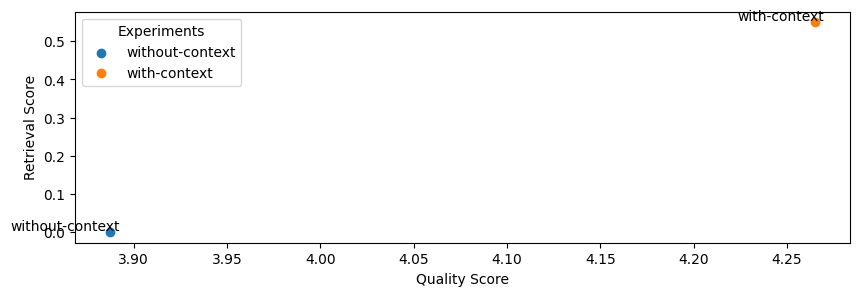

In [111]:
scores = {}
for experiment_name in ["without-context","with-context"]:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

#### 3. Varying chunk size

In [120]:
experiment_names = []
chunk_sizes = [300, 500, 750, 1000]

In [121]:
for chunk_size in chunk_sizes:
    experiment_name = f"chunk-size-{chunk_size}"
    experiment_names.append(experiment_name)
    print(f"Running experiment {experiment_name}\n\n")
    
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=chunk_size, 
        chunk_overlap=100, 
        num_chunks=5,
        embedding_model_name=embedding_model_name,
        embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|█████████████████████████████████████████| 151/151 [09:43<00:00,  3.86s/it]


chunk-size-300
  retrieval score: 0.5960264900662252
  quality score: 4.139072847682119

chunk-size-500
  retrieval score: 0.5894039735099338
  quality score: 4.317880794701987

chunk-size-750
  retrieval score: 0.5827814569536424
  quality score: 4.211920529801325

chunk-size-1000
  retrieval score: 0.5496688741721855
  quality score: 4.258278145695364



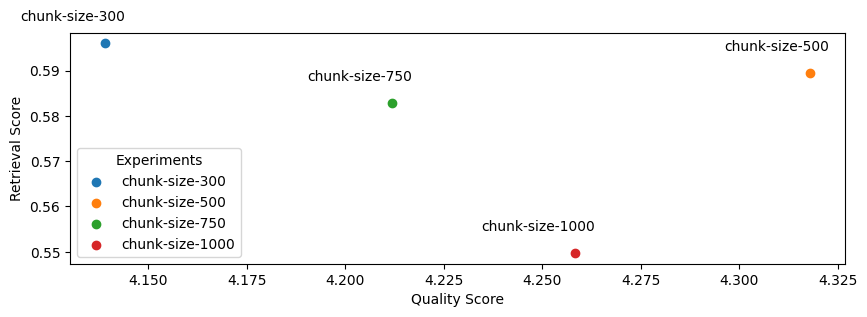

In [122]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

#### 4. Number of chunks

In [40]:
experiment_names = []
num_chunks_list = [1, 3, 5, 7, 10]

In [43]:
for num_chunks in num_chunks_list:
    experiment_name = f"num-chunks-{num_chunks}"
    experiment_names.append(experiment_name)
    run_experiment(
        experiment_name=experiment_name,
        chunk_size=500, 
        chunk_overlap=100, 
        num_chunks=num_chunks,
        embedding_model_name=embedding_model_name,
        embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|█████████████████████████████████████████| 151/151 [10:10<00:00,  4.05s/it]


num-chunks-1
  retrieval score: 0.1456953642384106
  quality score: 4.125827814569536

num-chunks-3
  retrieval score: 0.36423841059602646
  quality score: 4.2052980132450335

num-chunks-5
  retrieval score: 0.5894039735099338
  quality score: 4.33112582781457

num-chunks-7
  retrieval score: 0.6490066225165563
  quality score: 4.3841059602649

num-chunks-10
  retrieval score: 0.7086092715231788
  quality score: 4.344370860927152



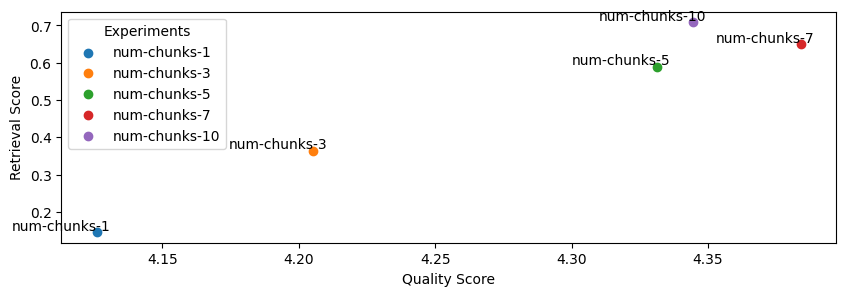

In [48]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

#### 5. Embedding models

In [49]:
experiment_names = []
embedding_model_names = ["thenlper/gte-base", "thenlper/gte-large", "text-embedding-3-large"]

In [50]:
for embedding_model_name in embedding_model_names:
    experiment_name = f"{embedding_model_name.split('/')[-1]}"
    experiment_names.append(experiment_name)
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=500, 
        chunk_overlap=100, 
        num_chunks=7,
        embedding_model_name=embedding_model_name,
        embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples= NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|█████████████████████████████████████████| 151/151 [08:13<00:00,  3.27s/it]


gte-base
  retrieval score: 0.6357615894039735
  quality score: 4.3509933774834435

gte-large
  retrieval score: 0.6556291390728477
  quality score: 4.337748344370861

text-embedding-3-large
  retrieval score: 0.6423841059602649
  quality score: 4.264900662251655



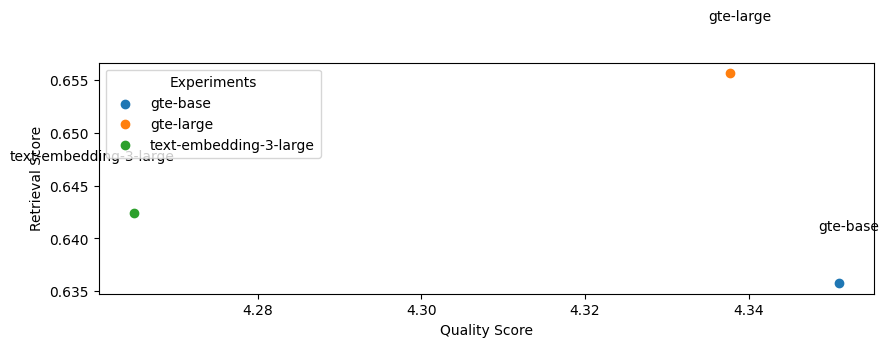

In [51]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)

#### 6. Open vs Closed Source LLMs

In [8]:
experiment_names = []
llms = ["gpt-4-turbo-2024-04-09",
        "meta-llama/Llama-2-70b-chat-hf",
        "mistralai/Mistral-7B-Instruct-v0.1",
        "mistralai/Mixtral-8x7B-Instruct-v0.1"]

embedding_model_name = "thenlper/gte-large"

In [9]:
for llm in llms:
    experiment_name = f"{llm.split('/')[-1].lower()}"
    experiment_names.append(experiment_name)
    print(llm)
    run_experiment(
        experiment_name=experiment_name, 
        chunk_size=500, 
        chunk_overlap=100, 
        num_chunks=7,
        embedding_model_name=embedding_model_name,
        embedding_dim=EMBEDDING_DIMENSIONS[embedding_model_name],
        llm=llm,
        evaluator=EVALUATOR,
        docs_dir=DOCS_DIR, 
        experiments_dir=EXPERIMENTS_DIR, 
        references_fp=REFERENCES_FILE_PATH,
        num_samples=NUM_SAMPLES)

<IPython.core.display.JSON object>

100%|█████████████████████████████████████████| 151/151 [08:30<00:00,  3.38s/it]


gpt-4-turbo-2024-04-09
  retrieval score: 0.6490066225165563
  quality score: 4.503311258278146

llama-2-70b-chat-hf
  retrieval score: 0.6556291390728477
  quality score: 4.072847682119205

mistral-7b-instruct-v0.1
  retrieval score: 0.6556291390728477
  quality score: 3.794701986754967

mixtral-8x7b-instruct-v0.1
  retrieval score: 0.6490066225165563
  quality score: 4.291390728476821



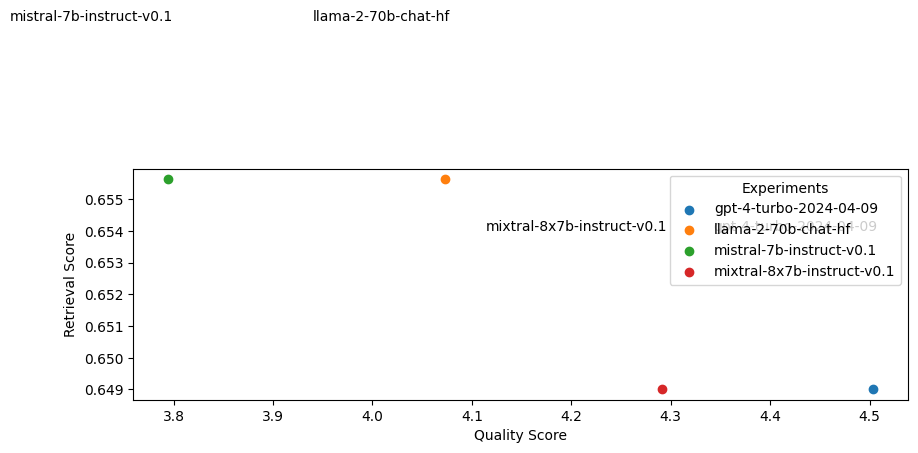

In [10]:
scores = {}
for experiment_name in experiment_names:
    scores[experiment_name] = print_experiment(experiment_name, EXPERIMENTS_DIR)
plot_scores(scores=scores)